# Data sampling and feature engineering

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
LEARNING_RATE = 0.05
DISPLAY_STEP = 100
NUM_STEPS = 1000

In [3]:
# Immediate execution
tf.enable_eager_execution()
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
# Source dataframe
df = pd.DataFrame(
    {
        'score': [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.],
        'cost': [30.0, 90.2, 125.4, 150.4, 169.8, 185.6, 199.0, 210.6, 220.8, 230.0]
    }
)

df

,score,cost
0,1.0,30.0
1,2.0,90.2
2,3.0,125.4
3,4.0,150.4
4,5.0,169.8
5,6.0,185.6
6,7.0,199.0
7,8.0,210.6
8,9.0,220.8
9,10.0,230.0


In [5]:
# Definition of linear equation
a = tfe.Variable(np.random.randn())
b = tfe.Variable(np.random.randn())

def linear_regression(inputs):
    return inputs * a + b

In [6]:
# Regression objective as minimization of error
def mean_square_fn(model_fn, inputs, labels):
    n_samples = int(tf.size(labels))
    return tf.reduce_sum(tf.pow(model_fn(inputs) - labels, 2)) / (2 * n_samples)

In [7]:
# Training optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
grad = tfe.implicit_gradients(mean_square_fn)

In [8]:
# Main regression routine
def make_regression(x, y):
    for step in range(NUM_STEPS):
        optimizer.apply_gradients(grad(linear_regression, x, y))
        if (step + 1) % DISPLAY_STEP == 0 or step == 0:
            print("Epoch:", '%04d' % (step + 1), "cost=",
                  "{:.9f}".format(mean_square_fn(linear_regression, x, y)),
                  "a=", a.numpy(), "b=", b.numpy())
    return a, b

In [9]:
# Plot results
def make_plot(x, y):
    plt.plot(x, y, 'ro', label='Original')
    plt.plot(x, np.array(a * x + b), label='Fitted')
    plt.legend()
    plt.show()

In [10]:
# Initial column preparation
simple_feature_column_score = tf.feature_column.numeric_column('score')
simple_feature_column_cost = tf.feature_column.numeric_column('cost')
feature_score = {'score': tf.convert_to_tensor(df['score'])}
feature_cost = {'cost': tf.convert_to_tensor(df['cost'])}
net_score = tf.feature_column.input_layer(feature_score, simple_feature_column_score)
net_cost = tf.feature_column.input_layer(feature_cost, simple_feature_column_cost)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
Colocations handled automatically by placer.
Epoch: 0001 cost= 13897.650390625 a= 52.46255 b= 9.614318
Epoch: 0100 cost= 209.697463989 a= 21.571527 b= 35.10564
Epoch: 0200 cost= 175.334686279 a= 20.786785 b= 45.579773
Epoch: 0300 cost= 172.439361572 a= 20.287212 b= 49.192673
Epoch: 0400 cost= 172.089523315 a= 20.107248 b= 50.449238
Epoch: 0500 cost= 172.047134399 a= 20.044437 b= 50.88654
Epoch: 0600 cost= 172.041976929 a= 20.022585 b= 51.03873
Epoch: 0700 cost= 172.041397095 a= 20.014977 b= 51.091705
Epoch: 0800 cost= 172.041305542 a= 20.012316 b= 51.11017
Epoch: 0900 cost= 172.041305542 a= 20.011398 b= 51.116585
Epoch: 1000 cost= 172.041336060 a= 20.011084 b= 51.118813


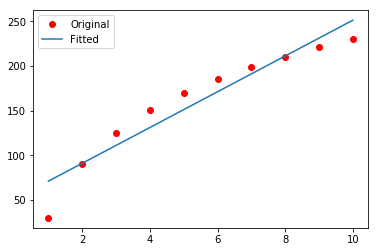

In [11]:
# First regression test
a, b = make_regression(net_score, net_cost)
make_plot(net_score, net_cost)

In [12]:
# Scaling test
val_mean = df['score'].mean()
val_std = df['score'].std()

def scaler(x):
    return (tf.cast(x, dtype=tf.float32) - val_mean) / val_std

scale_feature_column_score = tf.feature_column.numeric_column('score', normalizer_fn=scaler)
net_score_scale = tf.feature_column.input_layer(feature_score, scale_feature_column_score)

Epoch: 0001 cost= 6313.914062500 a= 21.836956 b= 56.621872
Epoch: 0100 cost= 172.327804565 a= 60.17997 b= 160.52838
Epoch: 0200 cost= 172.041336060 a= 60.581974 b= 161.17613
Epoch: 0300 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 0400 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 0500 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 0600 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 0700 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 0800 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 0900 cost= 172.041290283 a= 60.586002 b= 161.17986
Epoch: 1000 cost= 172.041290283 a= 60.586002 b= 161.17986


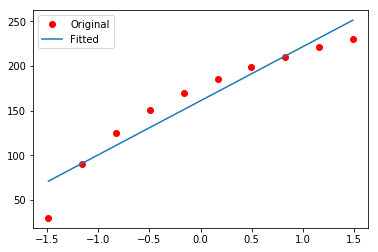

In [13]:
a, b = make_regression(net_score_scale, net_cost)
make_plot(net_score_scale, net_cost)

In [14]:
# Prepare moving average
df['cost_rolling'] = df['cost'].rolling(2, min_periods=1).mean()
df

,score,cost,cost_rolling
0,1.0,30.0,30.0
1,2.0,90.2,60.1
2,3.0,125.4,107.8
3,4.0,150.4,137.9
4,5.0,169.8,160.1
5,6.0,185.6,177.7
6,7.0,199.0,192.3
7,8.0,210.6,204.8
8,9.0,220.8,215.7
9,10.0,230.0,225.4


In [15]:
# Test of moving average regression
simple_feature_column_cost_rolling = tf.feature_column.numeric_column('cost_rolling')
feature_cost_rolling = {'cost_rolling': tf.convert_to_tensor(df['cost_rolling'])}
net_cost_rolling = tf.feature_column.input_layer(feature_cost_rolling, simple_feature_column_cost_rolling)

Epoch: 0001 cost= 60924.074218750 a= -50.008015 b= 144.0187
Epoch: 0100 cost= 362.532104492 a= 16.86304 b= 75.70212
Epoch: 0200 cost= 154.724319458 a= 19.264545 b= 48.483116
Epoch: 0300 cost= 135.115936279 a= 20.574886 b= 39.077953
Epoch: 0400 cost= 132.744735718 a= 21.043718 b= 35.8064
Epoch: 0500 cost= 132.457550049 a= 21.207243 b= 34.667824
Epoch: 0600 cost= 132.422775269 a= 21.264153 b= 34.271553
Epoch: 0700 cost= 132.418502808 a= 21.283968 b= 34.13364
Epoch: 0800 cost= 132.418014526 a= 21.290867 b= 34.085636
Epoch: 0900 cost= 132.417968750 a= 21.293264 b= 34.068924
Epoch: 1000 cost= 132.417984009 a= 21.294096 b= 34.063107


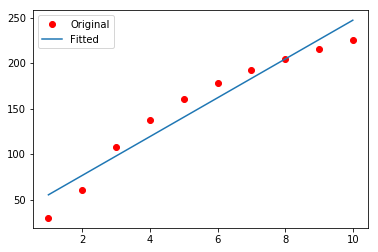

In [16]:
a, b = make_regression(net_score, net_cost_rolling)
make_plot(net_score, net_cost_rolling)

8. Dealing with categorical features
  
  8.1. Bucketing bins

8.2. One-Hot encoding

In [17]:
# Prepare bucketized data
bucketized_feature_column_cost = tf.feature_column.bucketized_column(
    source_column = simple_feature_column_cost,
    boundaries = [50, 100, 150, 160, 180, 190, 200, 220, 225])

net_cost_bucket = tf.feature_column.input_layer(feature_cost, bucketized_feature_column_cost)
print(net_cost_bucket)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(10, 10), dtype=float32)


1.2 One hot decouding 

In [18]:
# Prepare plain bucket index
bucket_index = tf.reshape(tf.cast(tf.argmax(net_cost_bucket, axis=1), tf.float32), [-1, 1])
print(bucket_index)

tf.Tensor(
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]], shape=(10, 1), dtype=float32)


Epoch: 0001 cost= 11592.997070312 a= -27.414396 b= 26.729074
Epoch: 0100 cost= 21.836191177 a= 0.09374571 b= 10.058662
Epoch: 0200 cost= 1.566419959 a= 0.46994886 b= 2.818037
Epoch: 0300 cost= 0.188961983 a= 0.8097397 b= 0.3280028
Epoch: 0400 cost= 0.022888858 a= 0.9336257 b= -0.53782296
Epoch: 0500 cost= 0.002772587 a= 0.97689486 b= -0.839144
Epoch: 0600 cost= 0.000335850 a= 0.9919584 b= -0.94401556
Epoch: 0700 cost= 0.000040682 a= 0.997201 b= -0.9805153
Epoch: 0800 cost= 0.000004928 a= 0.9990255 b= -0.9932185
Epoch: 0900 cost= 0.000000597 a= 0.999661 b= -0.99763966
Epoch: 1000 cost= 0.000000072 a= 0.9998821 b= -0.99917835


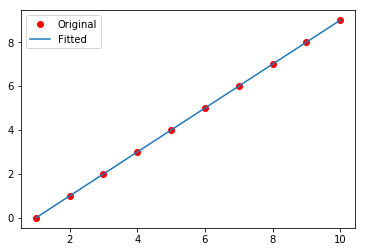

In [19]:
a, b = make_regression(net_score, bucket_index)
make_plot(net_score, bucket_index)

In [20]:
# Make a log transformation of data
def log_transformer(x):
    return tf.cast(tf.log(x), dtype=tf.float32)

log_feature_column_score = tf.feature_column.numeric_column('score', normalizer_fn=log_transformer)
net_score_log = tf.feature_column.input_layer(feature_score, log_feature_column_score)

Epoch: 0001 cost= 9844.056640625 a= 15.209748 b= 7.034268
Epoch: 0100 cost= 4.395976067 a= 82.80523 b= 37.045963
Epoch: 0200 cost= 1.155776262 a= 84.77604 b= 33.611935
Epoch: 0300 cost= 0.303934276 a= 85.78653 b= 31.851187
Epoch: 0400 cost= 0.079980686 a= 86.30466 b= 30.948378
Epoch: 0500 cost= 0.021103982 a= 86.57032 b= 30.485487
Epoch: 0600 cost= 0.005623897 a= 86.706535 b= 30.248133
Epoch: 0700 cost= 0.001554373 a= 86.77638 b= 30.12643
Epoch: 0800 cost= 0.000484552 a= 86.81218 b= 30.064035
Epoch: 0900 cost= 0.000203296 a= 86.830536 b= 30.032051
Epoch: 1000 cost= 0.000129330 a= 86.83994 b= 30.015665


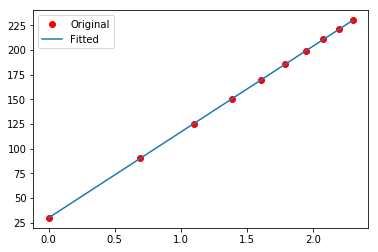

In [21]:
a, b = make_regression(net_score_log, net_cost)
make_plot(net_score_log, net_cost)